# Simple Keras example of Boston Housing regression

Keras, Tensorflow

Boston housing

This code is heavily inspired in section 3.4 of "Deep Learning with Python" book, by François Chollet

**Features:**
- Code at start avoids full GPU memory allocation. Some interesting threads about this:
-- https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
-- https://kobkrit.com/using-allow-growth-memory-option-in-tensorflow-and-keras-dc8c8081bc96
    


**1 - import data**

In [1]:
import keras as k
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()


Using TensorFlow backend.


**2 - input normalization**

In this dataset, features have different scales. It would burden the learning process if we fed them into the network as they are presented, so we normalize them.

In [2]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [3]:
print(train_data)

[[-0.27224633 -0.48361547 -0.43576161 ...  1.14850044  0.44807713
   0.8252202 ]
 [-0.40342651  2.99178419 -1.33391162 ... -1.71818909  0.43190599
  -1.32920239]
 [ 0.1249402  -0.48361547  1.0283258  ...  0.78447637  0.22061726
  -1.30850006]
 ...
 [-0.40202987  0.99079651 -0.7415148  ... -0.71712291  0.07943894
  -0.67776904]
 [-0.17292018 -0.48361547  1.24588095 ... -1.71818909 -0.98764362
   0.42083466]
 [-0.40422614  2.04394792 -1.20161456 ... -1.30866202  0.23317118
  -1.15392266]]


**3 - Define network architecture**

Dimensions of hidden layers -> each layer can potentially become an information bottleneck. We need enough units for the size of the information we are trying to learn. A small sized layer in between can dropout important information than can never be recovered. We are trying to learn 46 different classes here, so we are using large layers.

In [4]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    
    #last layer has only one unit and no activation function:
    model.add(layers.Dense(1))
    
    #metric: mae -> mean absolute error
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model


**5 - Train and K-fold eval**

In [6]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [8]:
print(all_scores)
print(np.mean(all_scores))

[2.3487472109275287, 2.511665433940321, 3.2305252174339674, 2.454075521761828]
2.6362533460159114


In [30]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


**6 - Show loss performance**

In [22]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

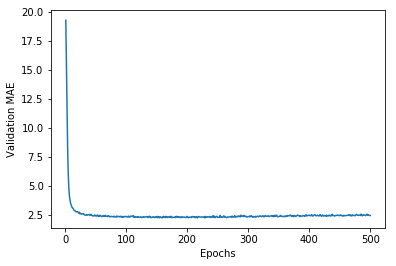

In [23]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

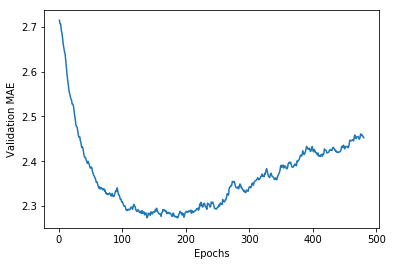

In [24]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[20:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [28]:
model = build_model()
model.fit(train_data, train_targets,
epochs=80, batch_size=512, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)


102/102 [==============================] - 0s 1ms/step


In [29]:
print(test_mae_score)

7.20035597857307
